## Task 1

### A. Importing required libraries + Connecting to local database

Importing libraries

In [1]:
import pandas as pd 
import numpy as np
import plotly.express as px 
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy import text
import plotly.io as pio
import psycopg2, requests, psycopg2.extras, json, os, time
pio.renderers.default = 'iframe'


Connecting to local database

In [2]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn
    

db, conn = pgconnect(credentials)

Connected successfully.


converts SQL query result into a Python

In [3]:
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

### B. Importing and cleaning all the required datasets

#### Income Dataset

Replace Null placeholder 'np' into Null value in Python + Replace any non numeric value into 0.

In [4]:
incomedata = pd.read_csv('Income.csv')
incomedata.columns = map(str.lower, incomedata.columns)

incomedata = incomedata.replace('np', pd.NA)


numeric_cols = ['earners', 'median_income', 'mean_income']
for col in numeric_cols:
    incomedata[col] = pd.to_numeric(incomedata[col], errors='coerce')

incomedata[numeric_cols] = incomedata[numeric_cols].fillna(0)

incomedata.head()

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467.0,51,46640.0,68904.0
1,101021008,Karabar,5103.0,42,65564.0,69672.0
2,101021009,Queanbeyan,7028.0,39,63528.0,69174.0
3,101021010,Queanbeyan - East,3398.0,39,66148.0,74162.0
4,101021012,Queanbeyan West - Jerrabomberra,8422.0,44,78630.0,91981.0


Creating a table for income dataset in SQL +
Import income dataset from Python dataframe into SQL table

In [5]:
conn.execute(text("""
DROP TABLE IF EXISTS income;
CREATE TABLE income(
    sa2_code21 INT PRIMARY KEY,
    sa2_name VARCHAR(100),
    earners INT,
    median_income NUMERIC,
    mean_income NUMERIC
);
    CREATE INDEX income_median_income_ind ON income(median_income)
"""))

incomedata = incomedata[['sa2_code21', 'sa2_name', 'earners', 'median_income', 'mean_income']]
incomedata.to_sql("income", con=conn, if_exists='append', index=False)
query(conn, "select * from income")

,sa2_code21,sa2_name,earners,median_income,mean_income
0,101021007,Braidwood,2467,46640.0,68904.0
1,101021008,Karabar,5103,65564.0,69672.0
2,101021009,Queanbeyan,7028,63528.0,69174.0
3,101021010,Queanbeyan - East,3398,66148.0,74162.0
4,101021012,Queanbeyan West - Jerrabomberra,8422,78630.0,91981.0
...,...,...,...,...,...
637,128021537,Royal National Park,14,36980.0,47584.0
638,128021538,Sutherland - Kirrawee,13895,64940.0,74867.0
639,128021607,Engadine,10239,63695.0,72995.0
640,128021608,Loftus - Yarrawarrah,4424,63087.0,76440.0


#### Businesses Dataset

Converting the columns names into lowercase

In [6]:
businessdata = pd.read_csv('Businesses.csv')
businessdata.columns = map(str.lower, businessdata.columns)

businessdata.columns

Index(['industry_code', 'industry_name', 'sa2_code', 'sa2_name',
       '0_to_50k_businesses', '50k_to_200k_businesses',
       '200k_to_2m_businesses', '2m_to_5m_businesses', '5m_to_10m_businesses',
       '10m_or_more_businesses', 'total_businesses'],
      dtype='object')

Create PostGIS table + Insert value

In [7]:
conn.execute(text("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses(
    sa2_code INT,
    sa2_name VARCHAR(100),
    industry_code CHAR(1),
    industry_name VARCHAR(100),
    total_businesses INT,
    PRIMARY KEY (sa2_code, industry_code)
);
    CREATE INDEX businesses_sa2_code_ind ON businesses(sa2_code)         
"""))

businessdata = businessdata[['sa2_code', 'sa2_name', 'industry_code', 'industry_name', 'total_businesses']]
businessdata.to_sql("businesses", con=conn, if_exists= 'append', index = False)
query(conn, "select * from businesses")

,sa2_code,sa2_name,industry_code,industry_name,total_businesses
0,101021007,Braidwood,A,"Agriculture, Forestry and Fishing",296
1,101021008,Karabar,A,"Agriculture, Forestry and Fishing",9
2,101021009,Queanbeyan,A,"Agriculture, Forestry and Fishing",15
3,101021010,Queanbeyan - East,A,"Agriculture, Forestry and Fishing",3
4,101021012,Queanbeyan West - Jerrabomberra,A,"Agriculture, Forestry and Fishing",16
...,...,...,...,...,...
12212,128021538,Sutherland - Kirrawee,S,Other Services,152
12213,128021607,Engadine,S,Other Services,87
12214,128021608,Loftus - Yarrawarrah,S,Other Services,22
12215,128021609,Woronora Heights,S,Other Services,9


#### Population Dataset

Create a column with people between age 0-19 called 'young_people'

In [8]:
popdata = pd.read_csv('Population.csv')
popdata.columns = map(str.lower, popdata.columns)

popdata['young_people'] = (
    popdata['0-4_people'] +
    popdata['5-9_people'] +
    popdata['10-14_people'] +
    popdata['15-19_people']
)

popdata.head()

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people,young_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,602,570,520,464,369,226,142,70,7530,2121
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,794,895,863,925,603,331,264,11052,2471
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,436,422,397,327,264,190,100,75,4748,961
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,882,901,930,917,1065,976,773,1028,14803,3205
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1241,1377,1285,1166,949,664,476,537,21346,4364


Create PostGIS table + Insert value

In [9]:
conn.execute(text("""
DROP TABLE IF EXISTS population;
CREATE TABLE population(
    sa2_code INT PRIMARY KEY,
    sa2_name VARCHAR(100),
    total_people INT, 
    young_people INT
);
"""))


popdata = popdata[['sa2_code', 'sa2_name', 'total_people', 'young_people']]
popdata.to_sql("population", con=conn, if_exists= 'append', index = False)
query(conn, "select * from population")

,sa2_code,sa2_name,total_people,young_people
0,102011028,Avoca Beach - Copacabana,7530,2121
1,102011029,Box Head - MacMasters Beach,11052,2471
2,102011030,Calga - Kulnura,4748,961
3,102011031,Erina - Green Point,14803,3205
4,102011032,Gosford - Springfield,21346,4364
...,...,...,...,...
368,128021537,Royal National Park,45,20
369,128021538,Sutherland - Kirrawee,23369,5078
370,128021607,Engadine,17379,5118
371,128021608,Loftus - Yarrawarrah,7354,2073


#### SA2 regions Dataset

Check the PostGIS version (not required)

In [10]:
query(conn, "select PostGIS_Version()")
srid = 4283

Import the SA2 region dataset

In [11]:
sa2_regions = gpd.read_file("SA2_2021_AUST_GDA2020.shp")
sa2_regions = sa2_regions[sa2_regions['GCC_NAME21'] == 'Greater Sydney']
sa2_regions.head()

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((151.20449 -33.5328, 151.20448 ..."
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


write SA2_regions table with PostGIS multipolygon colum

In [12]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

sa2_regions_og = sa2_regions.copy()
sa2_regions['geom'] = sa2_regions['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
sa2_regions = sa2_regions.drop(columns="geometry")

sa2_regions.columns = map(str.lower, sa2_regions.columns)
sa2_regions.head()

,sa2_code21,sa2_name21,chg_flag21,chg_lbl21,sa3_code21,sa3_name21,sa4_code21,sa4_name21,gcc_code21,gcc_name21,ste_code21,ste_name21,aus_code21,aus_name21,areasqkm21,loci_uri21,geom
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.32348639265098 -33.4277852...


Create PostGIS table + Insert value

In [13]:
conn.execute(text("""DROP TABLE IF EXISTS sa2_regions;
CREATE TABLE sa2_regions (
    sa2_code21 INT PRIMARY KEY,
    sa2_name21 VARCHAR(100),
    sa4_code21 INT,
    sa4_name21 VARCHAR(100),
    areasqkm21 NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4283)
);   
    CREATE INDEX sa2_regions_geom_ind ON sa2_regions USING GIST (geom)"""
))

sa2_regions = sa2_regions[['sa2_code21', 'sa2_name21', 'sa4_code21', 'sa4_name21', 'areasqkm21', 'geom']]
sa2_regions.to_sql("sa2_regions", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2_regions limit 10")

,sa2_code21,sa2_name21,sa4_code21,sa4_name21,areasqkm21,geom
0,102011028,Avoca Beach - Copacabana,102,Central Coast,6.4376,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,102,Central Coast,32.0802,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,102,Central Coast,767.9512,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,102,Central Coast,33.7934,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,102,Central Coast,16.9123,0106000020BB100000010000000103000000010000007E...
5,102011033,Kariong,102,Central Coast,8.3063,0106000020BB100000010000000103000000010000000F...
6,102011034,Kincumber - Picketts Valley,102,Central Coast,11.7169,0106000020BB1000000100000001030000000100000029...
7,102011035,Narara,102,Central Coast,7.7021,0106000020BB1000000100000001030000000100000009...
8,115011555,Castle Hill - North,115,Sydney - Baulkham Hills and Hawkesbury,6.8149,0106000020BB10000001000000010300000001000000FA...
9,119031667,Penshurst,119,Sydney - Inner South West,1.6722,0106000020BB10000001000000010300000001000000A7...


#### Public Transportation Dataset

In [14]:
stops = pd.read_csv('Stops.txt')
stops.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN


Convert latitude and longitude into shapely point(coordinate) called "geom"

In [15]:
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops = stops.drop(columns=['stop_lat', 'stop_lon'])
stops.head()

srid = 4283
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
stops

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,NaN,POINT (151.20666465471 -33.8822064874687)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,NaN,POINT (151.20699145565 -33.8820421431408)
2,200060,NaN,Central Station,1.0,NaN,0,NaN,POINT (151.206292455081 -33.8840842535493)
3,201510,NaN,Redfern Station,1.0,NaN,0,NaN,POINT (151.198866071817 -33.8916900512711)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,NaN,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,POINT (151.07879697831 -33.8220164586429)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1,1A,POINT (151.116926480557 -33.8406690716775)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1,1B,POINT (151.116898892402 -33.8407691073139)
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1,NaN,POINT (151.010576673346 -33.8139042429414)


Create PostGIS table + Insert value

In [16]:
conn.execute(text("""DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(20) PRIMARY KEY,
    stop_name VARCHAR(100),
    wheelchair_boarding INT,
    geom GEOMETRY(POINT,4283)
);
    CREATE INDEX stops_geom_ind ON stops USING GIST (geom)"""
))

stops = stops[['stop_id', 'stop_name', 'wheelchair_boarding', 'geom']]
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from stops limit 10")

,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,0101000020BB100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,"Central Station, Eddy Av, Stand D",0,0101000020BB1000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,Central Station,0,0101000020BB100000817FA2F299E662408FF33DAC29F1...
3,201510,Redfern Station,0,0101000020BB1000009E57611C5DE6624060304CE622F2...
4,201646,"Redfern Station, Gibbons St, Stand B",0,0101000020BB100000DBF9333D5DE662403DFA6B9D58F2...
5,204230,"St Peters Station, King St",0,0101000020BB100000B31F3BB6CBE5624076DF921A02F4...
6,204311,King St Opp St Peters Station,0,0101000020BB100000AFE292CACDE56240627AB7A805F4...
7,204313,Erskineville Rd At Charles St,0,0101000020BB1000004D466749E9E562404F71D1CD29F3...
8,204320,Erskineville Rd At Prospect St,0,0101000020BB100000AC12B4FDE2E562407FD9B1E328F3...
9,204410,St Peters Station,0,0101000020BB1000006EC9C4A4C8E56240FECD638521F4...


### C. Ingest 3 different types of school data
1. Import the dataset into Python
2. Transforms geometry data into PostGIS-compatible WKT format with SRID
3. Create a table in SQL and import the dataset from Python to SQL

#### Primary Schools

In [17]:
primary_sch = gpd.read_file("catchments_primary.shp")
primary_sch.columns = map(str.lower, primary_sch.columns)
primary_sch.head()

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.7296, 150.92602 -33.72..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [18]:
srid = 4283
primary_sch_og = primary_sch.copy()
primary_sch['geom'] = primary_sch['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
primary_sch = primary_sch.drop(columns="geometry")
primary_sch.head()

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1537883781186 -33.75586174...


In [19]:
conn.execute(text("""DROP TABLE IF EXISTS primary_sch;
CREATE TABLE primary_sch (
    use_id INT PRIMARY KEY,
    catch_type VARCHAR(50),
    geom GEOMETRY(MULTIPOLYGON, 4283)
);   
    CREATE INDEX primary_sch_geom_ind ON primary_sch USING GIST (geom)"""
))

primary_sch = primary_sch[['use_id', 'catch_type', 'geom']]
primary_sch.to_sql("primary_sch", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from primary_sch limit 10")

,use_id,catch_type,geom
0,2838,PRIMARY,0106000020BB1000000100000001030000000100000078...
1,2404,PRIMARY,0106000020BB10000001000000010300000001000000BE...
2,4393,PRIMARY,0106000020BB1000000100000001030000000100000065...
3,4405,PRIMARY,0106000020BB1000000100000001030000000100000048...
4,4615,PRIMARY,0106000020BB1000000100000001030000000100000056...
5,3918,PRIMARY,0106000020BB1000000100000001030000000100000042...
6,3396,PRIMARY,0106000020BB10000001000000010300000001000000E1...
7,2304,PRIMARY,0106000020BB1000000100000001030000000100000001...
8,4398,PRIMARY,0106000020BB1000000100000001030000000100000073...
9,4286,PRIMARY,0106000020BB10000001000000010300000001000000AE...


#### Secondary Schools

In [20]:
sec_sch = gpd.read_file("catchments_secondary.shp")
sec_sch.columns = map(str.lower, sec_sch.columns)
primary_sch.head()


,use_id,catch_type,geom
0,2838,PRIMARY,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,MULTIPOLYGON (((151.1537883781186 -33.75586174...


In [21]:
sec_sch_og = sec_sch.copy()
sec_sch['geom'] = sec_sch['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
sec_sch = sec_sch.drop(columns="geometry")
sec_sch.head()

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.67182402032344 -35.3144375...
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((147.08733806259178 -35.8627146...
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.81447829547324 -35.7834062...
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((150.68599834118749 -33.7403060...
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((150.69513440644116 -33.7562688...


In [22]:
conn.execute(text("""DROP TABLE IF EXISTS sec_sch;
CREATE TABLE sec_sch (
    use_id INT PRIMARY KEY,
    catch_type VARCHAR(50),
    geom GEOMETRY(MULTIPOLYGON, 4283)
);   
    CREATE INDEX sec_sch_geom_ind ON sec_sch USING GIST (geom)"""
))

sec_sch = sec_sch[['use_id', 'catch_type', 'geom']]
sec_sch.to_sql("sec_sch", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sec_sch limit 10")

,use_id,catch_type,geom
0,8503,HIGH_COED,0106000020BB100000010000000103000000010000006D...
1,8266,HIGH_COED,0106000020BB1000000100000001030000000100000071...
2,8559,HIGH_COED,0106000020BB100000010000000103000000020000002F...
3,8502,HIGH_COED,0106000020BB100000010000000103000000010000003B...
4,8505,HIGH_COED,0106000020BB100000010000000103000000010000003F...
5,8458,HIGH_COED,0106000020BB1000000200000001030000000100000096...
6,8227,HIGH_COED,0106000020BB100000010000000103000000010000006E...
7,8384,HIGH_COED,0106000020BB1000000100000001030000000100000084...
8,8404,HIGH_COED,0106000020BB100000010000000103000000010000008F...
9,8536,HIGH_COED,0106000020BB1000000100000001030000000100000055...


#### Future schools

In [23]:
f_sch = gpd.read_file("catchments_future.shp")
f_sch.columns = map(str.lower, f_sch.columns)
f_sch.head()


,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.5399, 151.19945 -33.54..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.6982, 151.17859 -33.69..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [24]:
f_sch_og = f_sch.copy()
f_sch['geom'] = f_sch['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
f_sch = f_sch.drop(columns="geometry")
f_sch.head()

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.19848917708944 -33.5398987...
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.27151530428182 -33.9140183...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,MULTIPOLYGON (((151.15292370935092 -33.8393921...
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.17793729938725 -33.6982001...
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.28072275958445 -33.8328728...


In [25]:
conn.execute(text("""DROP TABLE IF EXISTS f_sch;
CREATE TABLE f_sch (
    use_id INT PRIMARY KEY,
    catch_type VARCHAR(50),
    geom GEOMETRY(MULTIPOLYGON, 4283)
);   
    CREATE INDEX f_sch_geom_ind ON f_sch USING GIST (geom)"""
))

f_sch = f_sch[['use_id', 'catch_type', 'geom']]
f_sch.to_sql("f_sch", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from f_sch limit 10")

,use_id,catch_type,geom
0,8416,HIGH_COED,0106000020BB1000000100000001030000000100000090...
1,8161,HIGH_BOYS,0106000020BB100000010000000103000000010000006F...
2,8539,HIGH_COED,0106000020BB10000001000000010300000001000000E3...
3,8286,HIGH_COED,0106000020BB1000000100000001030000000100000099...
4,4524,PRIMARY,0106000020BB1000000100000001030000000100000060...
5,8554,HIGH_COED,0106000020BB10000001000000010300000001000000FE...
6,8400,HIGH_COED,0106000020BB1000000100000001030000000100000060...
7,8555,HIGH_COED,0106000020BB100000010000000103000000010000000C...
8,8135,HIGH_COED,0106000020BB100000010000000103000000010000001F...
9,8556,CENTRAL_HIGH,0106000020BB1000000100000001030000000100000028...


## Task 2

### A. Define the POI function

Define the POI function

In [26]:
response = requests.get("https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer")
response

<Response [200]>

In [27]:
def get_pois_from_bbox(minx, miny, maxx, maxy, wkid=4283):
    baseURL = ("https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query")
    envelope = {
        "xmin": minx,
        "ymin": miny,
        "xmax": maxx,
        "ymax": maxy,
        "spatialReference": {"wkid": wkid}
    }
    params = {
        "geometry": json.dumps(envelope),
        "geometryType": "esriGeometryEnvelope",
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "*",
        "returnGeometry": "true",
        "f": "json"
    }
    resp = requests.get(baseURL, params=params)
    if not resp.ok:
        print("POI API error", resp.status_code)
        return []
    return resp.json().get("features", [])

Seperate SA2 regions according to the chosen SA4 regions

In [28]:
sa4_region_parramatta = sa2_regions_og[sa2_regions_og["SA4_NAME21"] == "Sydney - Parramatta"].to_crs(epsg=4283)
sa4_region_blacktown = sa2_regions_og[sa2_regions_og['SA4_NAME21'] == 'Sydney - Northern Beaches'].to_crs(epsg=4283)
sa4_region_northernbeaches = sa2_regions_og[sa2_regions_og['SA4_NAME21'] == 'Sydney - Blacktown'].to_crs(epsg=4283)

sa4_regions = pd.concat([
    sa4_region_parramatta,
    sa4_region_blacktown,
    sa4_region_northernbeaches
])

### B. Loop through all the chosen SA2 regions

Loop through SA2 regions in the selected SA4 zones and collect all the POI features

In [29]:
records = []

for _, row in sa4_regions.iterrows():
    minx, miny, maxx, maxy = row.geometry.bounds
    features = get_pois_from_bbox(minx, miny, maxx, maxy)
    for feat in features:
        a = feat["attributes"]
        g = feat["geometry"]
        records.append({
            "sa2_code21": row["SA2_CODE21"],
            "sa2_name21": row["SA2_NAME21"],
            "objectid":   a.get("objectid"),
            "poiname":    a.get("poiname"),
            "poigroup":   a.get("poigroup"),
            "poitype":    a.get("poitype"),
            "lastupdate": a.get("lastupdate"),
            "lon":        g.get("x"),
            "lat":        g.get("y")
        })
    time.sleep(1)


Building a Panda DataFrame + GeoDataFrame

In [30]:
poi_df = pd.DataFrame(records)
poi_df.columns = map(str.lower, poi_df.columns)

poi_gdf = gpd.GeoDataFrame(
    poi_df,
    geometry=gpd.points_from_xy(poi_df.lon, poi_df.lat),
    crs="EPSG:4326"
)
poi_gdf = poi_gdf.to_crs(epsg=4283)

### C. Ingested the result into localhost database

Creating PostGIS table

In [31]:
conn.execute(text("""
  DROP TABLE IF EXISTS regions_pois;
  CREATE TABLE regions_pois (
    sa2_code21   INT,
    sa2_name21   TEXT,
    objectid     INT,
    poiname      TEXT,
    poigroup     INT,
    poitype      TEXT,
    lastupdate   BIGINT,
    lon          DOUBLE PRECISION,
    lat          DOUBLE PRECISION,
    geom         GEOMETRY(POINT,4283)
  );
  CREATE INDEX ON regions_pois USING GIST(geom);
"""))

poi_gdf["geom"] = poi_gdf.geometry.apply(
    lambda geom: WKTElement(geom.wkt, srid=4283)
)
poi_gdf.drop(columns="geometry", inplace=True)

poi_gdf.to_sql(
    "regions_pois",
    conn,
    if_exists="append",
    index=False,
    dtype={"geom": Geometry("POINT", srid=4283)}
)

print(f"Task 2 complete: ingested {len(poi_gdf)} POIs into regions_pois.")

Task 2 complete: ingested 10089 POIs into regions_pois.


## Task 3

#### A. Calculating the z-score

In [32]:
sql = """
CREATE OR REPLACE VIEW z_score AS
WITH
  sa2_list AS (
    SELECT sr.sa2_code21, sr.sa4_name21, sr.geom
      FROM sa2_regions sr
      JOIN population pop ON pop.sa2_code = sr.sa2_code21
     WHERE sr.sa4_name21 IN ('Sydney - Parramatta', 'Sydney - Blacktown', 'Sydney - Northern Beaches')
       AND pop.total_people >= 100
  ),

  biz AS (
    SELECT
      b.sa2_code       AS sa2_code21,
      (SUM(b.total_businesses)::float 
         / NULLIF(p.total_people,0)) * 1000 AS businesses_per_1000
    FROM businesses b
    JOIN population p
      ON p.sa2_code = b.sa2_code
    JOIN sa2_list l
      ON l.sa2_code21 = b.sa2_code
    WHERE b.industry_code IN ('F','G','H','K')
    GROUP BY b.sa2_code, p.total_people
  ),

  stops AS (
    SELECT
      sr.sa2_code21,
      COUNT(s.stop_id)::float AS stops_cnt
    FROM sa2_list l
    JOIN sa2_regions sr
      ON sr.sa2_code21 = l.sa2_code21
    LEFT JOIN stops s
      ON ST_Contains(
           ST_Transform(sr.geom, 4283),
           ST_Transform(s.geom, 4283)
         )
    GROUP BY sr.sa2_code21
  ),

  schools AS (
    SELECT
      sr.sa2_code21,
      (COUNT(sc.use_id)::float 
         / NULLIF(p.young_people,0)) * 1000 AS schools_per_1000
    FROM sa2_list l
    JOIN sa2_regions sr
      ON sr.sa2_code21 = l.sa2_code21
    JOIN population p
      ON p.sa2_code = sr.sa2_code21
    LEFT JOIN (
      SELECT use_id, geom FROM primary_sch
      UNION ALL
      SELECT use_id, geom FROM sec_sch
      UNION ALL
      SELECT use_id, geom FROM f_sch
    ) sc
      ON ST_Intersects(
           ST_Transform(sr.geom,4283),
           sc.geom
         )
    GROUP BY sr.sa2_code21, p.young_people
  ),

  pois AS (
    SELECT
      sr.sa2_code21,
      COUNT(pp.geom)::float AS poi_cnt
    FROM sa2_list l
    JOIN sa2_regions sr
      ON sr.sa2_code21 = l.sa2_code21
    LEFT JOIN regions_pois pp
      ON ST_Contains(
           sr.geom,
           pp.geom
         )
    GROUP BY sr.sa2_code21
  )

SELECT
  l.sa2_code21,
  l.sa4_name21,
  l.geom,
  COALESCE(b.businesses_per_1000, 0) AS businesses_per_1000,
  COALESCE(st.stops_cnt, 0) AS stops_cnt,
  COALESCE(sc.schools_per_1000, 0) AS schools_per_1000,
  COALESCE(poi.poi_cnt, 0) AS poi_cnt
FROM sa2_list l
LEFT JOIN biz     b   USING (sa2_code21)
LEFT JOIN stops   st  USING (sa2_code21)
LEFT JOIN schools sc  USING (sa2_code21)
LEFT JOIN pois    poi USING (sa2_code21)
ORDER BY l.sa2_code21;
"""
conn.execute(text(sql))
df = query(conn, "SELECT * FROM z_score;")
df.columns = [c.lower() for c in df.columns]
print(df.head())

   sa2_code21          sa4_name21  \
0   116011303  Sydney - Blacktown   
1   116011304  Sydney - Blacktown   
2   116011306  Sydney - Blacktown   
3   116011307  Sydney - Blacktown   
4   116011560  Sydney - Blacktown   

                                                geom  businesses_per_1000  \
0  0106000020BB10000001000000010300000001000000D0...            32.766849   
1  0106000020BB10000001000000010300000001000000CB...             8.967745   
2  0106000020BB1000000100000001030000000100000061...             9.278482   
3  0106000020BB100000010000000103000000010000004A...            22.961080   
4  0106000020BB1000000100000001030000000100000008...             8.515335   

   stops_cnt  schools_per_1000  poi_cnt  
0      228.0          5.117707    175.0  
1      234.0          3.360717    102.0  
2      221.0          2.711324    173.0  
3      345.0          3.203661    175.0  
4       82.0          2.366864     74.0  


#### B. Calculating the final score

In [33]:
conn.execute(text("""
DROP TABLE IF EXISTS regions_scores;

CREATE TABLE regions_scores AS
WITH z AS (
  SELECT
    sa2_code21,
    sa4_name21,
    geom,
  

    (businesses_per_1000 - AVG(businesses_per_1000) OVER ()) 
      / NULLIF(STDDEV_POP(businesses_per_1000) OVER (),0)
      AS businesses_z,

    (stops_cnt - AVG(stops_cnt) OVER ()) 
      / NULLIF(STDDEV_POP(stops_cnt) OVER (),0)
      AS stops_z,

    (schools_per_1000 - AVG(schools_per_1000) OVER ()) 
      / NULLIF(STDDEV_POP(schools_per_1000) OVER (),0)
      AS schools_z,

    (poi_cnt - AVG(poi_cnt) OVER ()) 
      / NULLIF(STDDEV_POP(poi_cnt) OVER (),0)
      AS poi_z

  FROM z_score   -- your view of raw metrics
)

SELECT
  sa2_code21,
  sa4_name21,
  geom,
  businesses_z,
  stops_z,
  schools_z,
  poi_z,

  1.0 / (
    1.0 + EXP(
      - (businesses_z + stops_z + schools_z + poi_z)
    )
  ) AS score

FROM z
ORDER BY score DESC;
"""))

#### D. Filter by SA4 regions

For all SA4 regions

In [34]:
query(conn, """
SELECT *
FROM regions_scores
ORDER BY score DESC;
""")

,sa2_code21,sa4_name21,geom,businesses_z,stops_z,schools_z,poi_z,score
0,122031432,Sydney - Northern Beaches,0106000020BB10000001000000010300000001000000AC...,1.282548,-0.639897,6.554900,0.218426,0.999399
1,125041717,Sydney - Parramatta,0106000020BB10000001000000010300000001000000FA...,4.742429,-1.358338,1.785993,0.577751,0.996820
2,122031429,Sydney - Northern Beaches,0106000020BB10000001000000010300000001000000DA...,1.931413,1.584507,-0.612666,0.952048,0.979272
3,116011303,Sydney - Blacktown,0106000020BB10000001000000010300000001000000D0...,1.173858,0.962779,0.830101,0.757414,0.976435
4,125041489,Sydney - Parramatta,0106000020BB1000000100000001030000000100000092...,0.151982,0.548294,0.148660,2.733704,0.972950
...,...,...,...,...,...,...,...,...
68,122031695,Sydney - Northern Beaches,0106000020BB1000000100000001030000000100000048...,-0.218351,-0.999118,-0.745686,-0.859551,0.056109
69,116021631,Sydney - Blacktown,0106000020BB100000010000000103000000010000003F...,-0.697303,-1.316890,0.285243,-1.338651,0.044464
70,116021629,Sydney - Blacktown,0106000020BB100000010000000103000000010000003D...,-0.550862,-0.971485,-0.194422,-1.353623,0.044345
71,116011560,Sydney - Blacktown,0106000020BB1000000100000001030000000100000008...,-1.025654,-1.054382,-0.494879,-0.754748,0.034567


Score compilation for Parramatta.

In [35]:
query(conn, """SELECT *
FROM regions_scores
Where sa4_name21 = 'Sydney - Parramatta'
ORDER BY score DESC
LIMIT 5""")

,sa2_code21,sa4_name21,geom,businesses_z,stops_z,schools_z,poi_z,score
0,125041717,Sydney - Parramatta,0106000020BB10000001000000010300000001000000FA...,4.742429,-1.358338,1.785993,0.577751,0.996820
1,125041489,Sydney - Parramatta,0106000020BB1000000100000001030000000100000092...,0.151982,0.548294,0.148660,2.733704,0.972950
2,125021477,Sydney - Parramatta,0106000020BB10000001000000010300000001000000B5...,0.300449,1.874647,0.098258,0.532835,0.943009
3,125011709,Sydney - Parramatta,0106000020BB100000010000000103000000010000005B...,3.826816,-1.082015,0.535721,-0.739776,0.926949
4,125031481,Sydney - Parramatta,0106000020BB10000001000000010300000001000000E9...,-0.002078,1.114757,-0.045846,1.086796,0.896007


Score compilation for Blacktown.

In [36]:
query(conn, """
SELECT *
FROM regions_scores
Where sa4_name21 = 'Sydney - Blacktown'
ORDER BY score DESC
LIMIT 5
""")

,sa2_code21,sa4_name21,geom,businesses_z,stops_z,schools_z,poi_z,score
0,116011303,Sydney - Blacktown,0106000020BB10000001000000010300000001000000D0...,1.173858,0.962779,0.830101,0.757414,0.976435
1,116011307,Sydney - Blacktown,0106000020BB100000010000000103000000010000004A...,0.284515,2.579272,-0.091825,0.757414,0.971512
2,116031319,Sydney - Blacktown,0106000020BB1000000100000001030000000100000016...,-0.657652,1.819382,-0.315710,1.101767,0.875205
3,116031317,Sydney - Blacktown,0106000020BB10000001000000010300000001000000CB...,-0.753049,1.170022,-0.621452,1.326346,0.754335
4,116011626,Sydney - Blacktown,0106000020BB1000000100000001030000000100000078...,-0.272485,-0.515552,0.666460,0.727470,0.647003


Score compilation for Northern Beaches

In [37]:
query(conn, """
SELECT *
FROM regions_scores
Where sa4_name21 = 'Sydney - Northern Beaches'
ORDER BY score DESC
LIMIT 5
""")

,sa2_code21,sa4_name21,geom,businesses_z,stops_z,schools_z,poi_z,score
0,122031432,Sydney - Northern Beaches,0106000020BB10000001000000010300000001000000AC...,1.282548,-0.639897,6.554900,0.218426,0.999399
1,122031429,Sydney - Northern Beaches,0106000020BB10000001000000010300000001000000DA...,1.931413,1.584507,-0.612666,0.952048,0.979272
2,122021421,Sydney - Northern Beaches,0106000020BB100000020000000103000000010000006E...,0.224308,0.368684,-0.034110,2.673816,0.962046
3,122021422,Sydney - Northern Beaches,0106000020BB10000002000000010300000001000000BA...,0.373604,-0.626081,-0.894118,4.185978,0.954322
4,122031696,Sydney - Northern Beaches,0106000020BB1000000100000001030000000100000015...,0.163830,0.921331,0.434736,0.173510,0.844672


## Task 4

Summarise key statistics for each SA4 zones 

In [38]:
query(conn, """
SELECT 
    sa4_name21, 
    MAX(score) AS max_score, 
    MIN(score) AS min_score
FROM regions_scores
WHERE sa4_name21 IN ('Sydney - Parramatta', 'Sydney - Blacktown', 'Sydney - Northern Beaches')
GROUP BY sa4_name21
ORDER BY max_score DESC;
""")

,sa4_name21,max_score,min_score
0,Sydney - Northern Beaches,0.999399,0.056109
1,Sydney - Parramatta,0.996820,0.070002
2,Sydney - Blacktown,0.976435,0.027243


We can visualise the distribution of score in each SA2 region by intensity. 

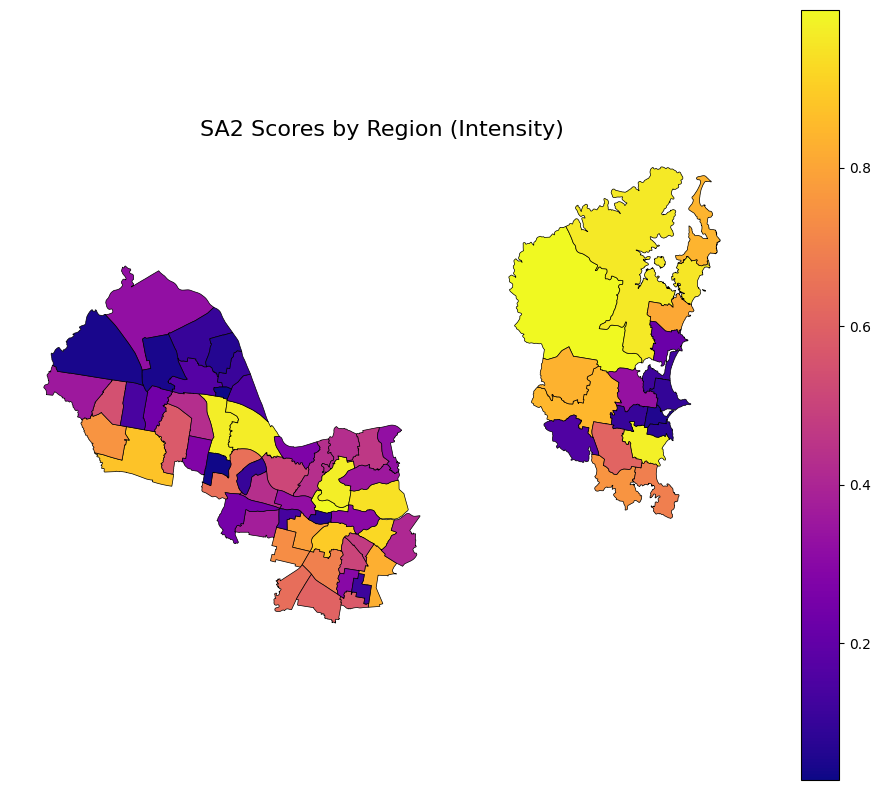

In [39]:
query = """
SELECT score, sa2_code21, geom 
FROM regions_scores
WHERE sa4_name21 IN ('Sydney - Blacktown', 'Sydney - Northern Beaches', 'Sydney - Parramatta')
"""

sa4_zones = gpd.read_postgis(query, conn, geom_col='geom', crs=4283)

# Plot score intensity using a continuous colormap
ax = sa4_zones.plot(
    column='score',         
    cmap='plasma',            
    legend=True,
    figsize=(12, 10),
    edgecolor='black',
    linewidth=0.5
)

ax.set_title("SA2 Scores by Region (Intensity)", fontsize=16)
ax.axis('off')
plt.show()

